In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
PATH = Path("data/soda_bottles")
arch = resnet34
bs = 32
sz = 224

In [ ]:
df = pd.read_csv(train_csv)
cols = df.columns.tolist()
cols = list(reversed(cols))
df = df[cols]
df.to_csv(PATH/'Images/train_ds.csv', index=False)

In [3]:
train_csv = PATH/'Images/train_ds.csv'
n = len(list(open(train_csv))) -1
cv_idxs = get_cv_idxs(n)

In [4]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'Images', train_csv, tfms=tfms, val_idxs=cv_idxs)
    return data

In [5]:
data = get_data(sz, bs)

In [6]:
data.trn_ds.fnames[0]

'Images/./M.Beer/1351_corrected.jpg'

In [6]:
data.c

8

In [7]:
m = arch(True)

In [8]:
children(m)[:-4]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(256, 64, kernel_size=(

In [8]:
m = nn.Sequential(*children(m)[:-2],
                  nn.Conv2d(512, 8, 3, padding=1),
                  nn.AdaptiveAvgPool2d(1), Flatten(),
                  nn.LogSoftmax())

In [11]:
m[-4]

Conv2d(512, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [12]:
m[-5]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 60/83 [00:54<00:21,  1.09it/s, loss=6.32]

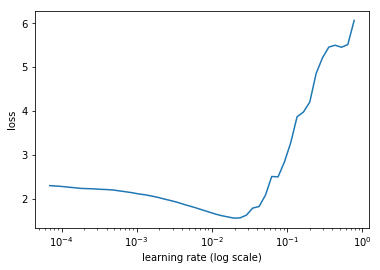

In [13]:
learn = ConvLearner.from_model_data(m, data)
learn.lr_find(wds=1e-4, end_lr=100)
learn.sched.plot(10, 1)

In [14]:
learn.freeze_to(-4)

In [15]:
m[-4].trainable

True

In [16]:
m[-1].trainable

True

In [17]:
learn.fit(0.01, 3, cycle_len=4, use_clr_beta=(40, 25, 0.95, 0.85), wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

  0%|          | 0/83 [00:00<?, ?it/s]                    


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.337057   0.768639   0.75359   
    1      1.41079    1.777305   0.672714                 
    2      0.896188   0.496299   0.842782                  
    3      0.532875   0.322151   0.89418                   
    4      0.610064   0.530403   0.830688                  
    5      0.748916   0.436835   0.858655                  
    6      0.649496   0.36252    0.870748                  
    7      0.431914   0.290245   0.889645                  
    8      0.534668   0.973978   0.779289                  
    9      1.103394   0.536221   0.833711                  
    10     0.73105    0.352927   0.883598                  
    11     0.434542   0.282983   0.904006                  



[array([0.28298]), 0.9040060465027686]

In [18]:
learn.fit(0.01, 1, cycle_len=50, use_clr=(15, 15, 0.95, 0.85), wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.470391   0.560042   0.832955  
    1      0.640841   0.89601    0.812547                  
    2      0.789719   1.055171   0.721844                  
    3      0.810374   0.415585   0.882842                  
    4      1.057246   0.821219   0.787604                  
    5      1.027175   0.614125   0.826909                  
    6      0.841946   0.638912   0.840514                  
    7      0.919596   1.421537   0.780045                  
    8      0.938313   1.114482   0.839002                  
    9      0.869377   1.004193   0.798942                  
    10     0.756225   0.831152   0.814815                  
    11     0.702336   0.389601   0.908541                  
    12     0.76487    0.481149   0.878307                  
    13     0.949053   0.705821   0.845805                  
    14     0.781547   0.805448   0.831444                  
    15     0.694581   0.662118   0.835223               

[array([0.2192]), 0.9365079365079365]

In [19]:
learn.save('CAM_default_size_soda_99_1cycle')

In [21]:
learn.fit(0.01, 3, cycle_len=3, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=21), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.812776   0.365593   0.91232   
    1      0.68025    0.453816   0.88511                   
    2      0.418562   0.299433   0.929705                  
    3      0.677039   0.536467   0.884354                  
    4      0.890404   0.422236   0.902494                  
    5      0.89688    0.476869   0.893424                  
    6      0.560653   0.319366   0.916856                  
    7      0.357766   0.341321   0.907029                  
    8      0.330501   0.308336   0.922147                  
    9      0.595008   2.170502   0.812547                  
    10     1.248673   0.498636   0.891912                  
    11     0.806279   0.889619   0.842026                  
    12     0.800668   0.605767   0.884354                  
    13     0.747015   0.511076   0.892668                  
    14     0.704468   0.541425   0.88511                   
    15     0.579786   0.66589    0.870748               

[array([0.31291]), 0.9206349206349206]

In [23]:
learn.save('CAM_default_size_soda_92_1cycle_final')

In [125]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
        self.test_input = input
    def remove(self): self.hook.remove()

In [80]:
from itertools import islice

In [81]:
def nth(iterable, n): return next(islice(iterable, n, None))

In [126]:
x, y = nth(data.val_dl, 7)

In [127]:
x, y = x[None, 1], y[None, 1]
vx = Variable(x.cuda(), requires_grad=True)

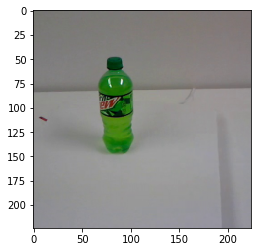

In [128]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [129]:
sfs = [SaveFeatures(o) for o in [m[-4]]]

In [130]:
%time py = m(vx)

CPU times: user 5.06 ms, sys: 71 µs, total: 5.13 ms
Wall time: 4.33 ms


In [131]:
for o in sfs: o.remove()

In [132]:
[o.features.size() for o in sfs]

[torch.Size([1, 8, 7, 7])]

In [137]:
py = np.exp(to_np(py)[0]); py

array([0.    , 0.0008, 0.9992, 0.    , 0.    , 0.    , 0.    , 0.    ], dtype=float32)

In [138]:
feat = np.maximum(0, to_np(sfs[0].features[0]))
feat.shape

(8, 7, 7)

In [139]:
f2 = np.dot(np.rollaxis(feat, 0, 3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.07164, 0.17613, 0.28055, 0.26168, 0.16027, 0.06933, 0.02151],
       [0.17091, 0.43715, 0.67707, 0.62909, 0.37294, 0.13951, 0.02967],
       [0.27624, 0.66924, 0.96932, 0.89409, 0.53157, 0.21223, 0.05455],
       [0.2977 , 0.70083, 1.     , 0.90354, 0.52802, 0.19923, 0.05153],
       [0.18582, 0.44451, 0.64853, 0.57948, 0.32384, 0.10906, 0.02332],
       [0.05334, 0.15785, 0.25312, 0.21394, 0.09099, 0.00595, 0.00003],
       [0.00002, 0.00006, 0.00009, 0.00008, 0.00005, 0.00002, 0.     ]], dtype=float32)

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


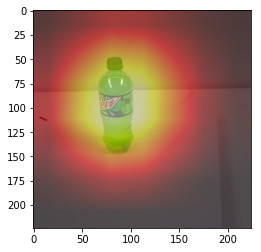

In [140]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot')

In [53]:
size_d = {k: PIL.Image.open(PATH/k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

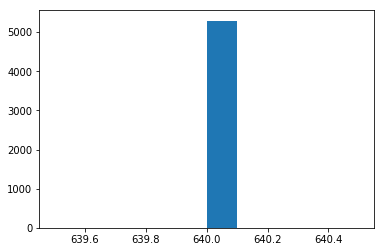

In [54]:
plt.hist(row_sz[row_sz<1000]);

In [55]:
data = data.resize(64, 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [57]:
learn.set_data(get_data(64, bs))

In [60]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 60/83 [00:00<00:00, 65.99it/s, loss=0.0659]


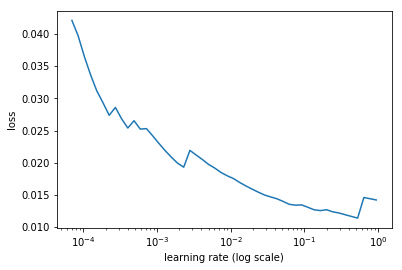

In [61]:
learn.sched.plot()

In [62]:
learn.precompute = False
learn.unfreeze()

In [63]:
lrs = [1e-9, 1e-6, 0.1]

In [64]:
learn.fit(lrs, 1, cycle_len=50, wds=1e-4, use_clr=(15, 15, 0.95, 0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.936174   0.897439   0.596372  
    1      1.227209   0.782628   0.652305                 
    2      1.088914   0.725383   0.684807                 
    3      1.029612   0.773266   0.644747                 
    4      0.980086   0.707941   0.683296                  
    5      0.950861   0.693572   0.686319                  
    6      0.937394   0.666252   0.699169                  
    7      0.919838   0.65871    0.693122                  
    8      0.889719   0.664276   0.694633                  
    9      0.885462   0.650627   0.724868                  
    10     0.873962   0.637322   0.708239                  
    11     0.884706   0.66367    0.696901                  
    12     0.887376   0.615378   0.727135                  
    13     0.87258    0.654679   0.687075                  
    14     0.849606   0.599444   0.724112                  
    15     0.861381   0.604418   0.752834                  


[array([0.45126]), 0.8148148140939725]

In [65]:
learn.freeze()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 77/83 [00:22<00:01,  3.49it/s, loss=2.75] 

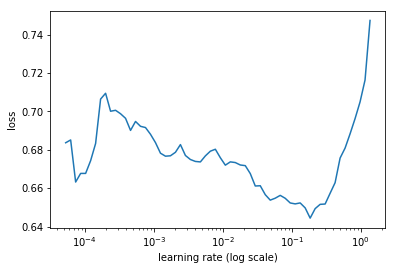

 93%|█████████▎| 77/83 [00:40<00:03,  1.92it/s, loss=2.75]

In [66]:
learn.lr_find()
learn.sched.plot()

In [67]:
learn.fit(0.15, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  8%|▊         | 7/83 [00:02<00:25,  2.93it/s, loss=0.634]


Exception in thread Thread-120:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.845263   0.624036   0.719577  
    1      0.884261   0.585128   0.725624                  
    2      0.913716   0.57027    0.751323                  



[array([0.57027]), 0.7513227518183304]